<a href="https://colab.research.google.com/github/WahyuKhairi06/BigData_2311531009_Wahyu-Khairi/blob/main/Tugas%20Akhir%20Big%20Data/Naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
rajatkumar30_fake_news_path = kagglehub.dataset_download('rajatkumar30/fake-news')

print('Data source import complete.')

Using Colab cache for faster access to the 'fake-news' dataset.
Data source import complete.


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news/news.csv


In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re, string
import warnings
import collections
from itertools import chain
warnings.filterwarnings('ignore')

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

Data distribution:
label
REAL    3154
FAKE    3152
Name: count, dtype: int64


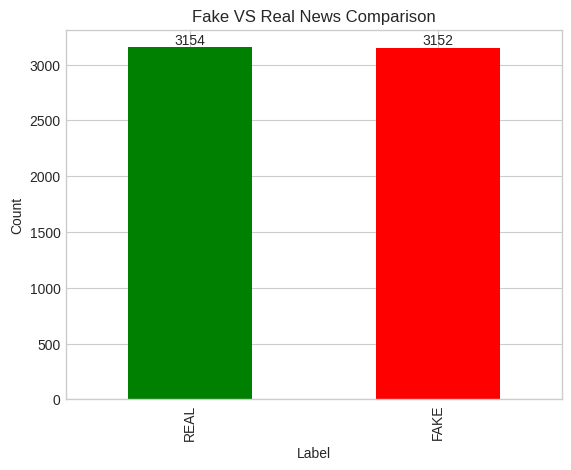

In [ ]:
df = pd.read_csv(rajatkumar30_fake_news_path + '/news.csv')

# Remove duplicates
df = df.drop_duplicates(subset=['text','title'])

# Check data distribution
print("Data distribution:")
print(df['label'].value_counts())

# Bar chart Fake vs Real Comparison
bar = df['label'].value_counts().plot(kind='bar',color=['green','red'])
for i in bar.patches:
    bar.text(i.get_x() + i.get_width()/2,i.get_height() + 0.1,
            f'{int(i.get_height())}',
            ha='center',va='bottom')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Fake VS Real News Comparison')
plt.show()

Preprocessing

In [ ]:
# Combine title and text
df['content'] = df['title'] + ' ' + df['text']

def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Remove punctuation / symbols, keep letters (a-z, A-Z), numbers (0-9), and whitespace
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # Remove extra whitespace (dilakukan sebelum tokenisasi untuk kebersihan)
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize the text
    word_tokens = word_tokenize(text)

    # Convert stopwords to lowercase for case-insensitive matching
    stop_words = set(stopwords.words('english'))

    # Filter out stopwords, keeping original case for non-stopwords
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]

    return ' '.join(filtered_text)


print("Cleaning text data...")
df['clean_content'] = df['content'].apply(clean_text)

label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])
print("\nLabel encoding:")
print(df[['label', 'label_encoded']].value_counts())

Cleaning text data...

Label encoding:
label  label_encoded
REAL   1                3154
FAKE   0                3152
Name: count, dtype: int64


In [ ]:
df.head()

,Unnamed: 0,title,text,label,content,clean_content,label_encoded
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,You Can Smell Hillary’s Fear Daniel Greenfield...,Smell Hillary Fear Daniel Greenfield Shillman ...,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,Watch The Exact Moment Paul Ryan Committed Pol...,Watch Exact Moment Paul Ryan Committed Politic...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,Kerry to go to Paris in gesture of sympathy U....,Kerry go Paris gesture sympathy U Secretary St...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,Bernie supporters on Twitter erupt in anger ag...,Bernie supporters Twitter erupt anger DNC trie...,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,The Battle of New York: Why This Primary Matte...,Battle New York Primary Matters primary day Ne...,1


In [ ]:
drop_columns = ['Unnamed: 0', 'title', 'text', 'label', 'content']
df.drop(drop_columns, axis=1, inplace=True)
df.head()

,clean_content,label_encoded
0,Smell Hillary Fear Daniel Greenfield Shillman ...,0
1,Watch Exact Moment Paul Ryan Committed Politic...,0
2,Kerry go Paris gesture sympathy U Secretary St...,1
3,Bernie supporters Twitter erupt anger DNC trie...,0
4,Battle New York Primary Matters primary day Ne...,1


Feature Extraction: TF-IDF

In [ ]:
X = df['clean_content']
y = df['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Create TF-IDF features
print("\nCreating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF Train shape: {X_train_tfidf.shape}")
print(f"TF-IDF Test shape: {X_test_tfidf.shape}")

Train set size: 5044
Test set size: 1262

Creating TF-IDF features...
TF-IDF Train shape: (5044, 5000)
TF-IDF Test shape: (1262, 5000)


Modelling and Evaluating: Naive Bayes

NAIVE BAYES MODEL TRAINING

Model Performance:
Accuracy:  0.8811
Precision: 0.9125
Recall:    0.8431
F1-Score:  0.8764

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.85      0.92      0.89       631
        REAL       0.91      0.84      0.88       631

    accuracy                           0.88      1262
   macro avg       0.88      0.88      0.88      1262
weighted avg       0.88      0.88      0.88      1262



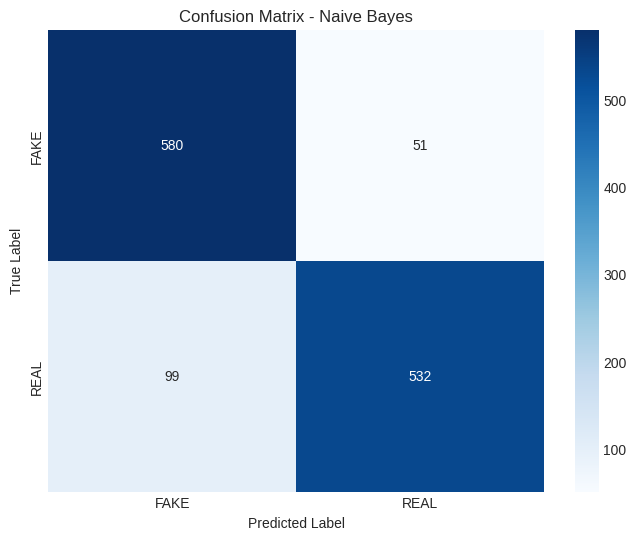

In [ ]:
print("="*50)
print("NAIVE BAYES MODEL TRAINING")
print("="*50)

nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)

y_pred = nb_model.predict(X_test_tfidf)
y_pred_prob = nb_model.predict_proba(X_test_tfidf)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nModel Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['FAKE', 'REAL']))

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['FAKE', 'REAL'],
            yticklabels=['FAKE', 'REAL'])
plt.title('Confusion Matrix - Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
print("="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

feature_names = tfidf_vectorizer.get_feature_names_out()
log_prob = nb_model.feature_log_prob_

top_n = 20
print("\nTop features for FAKE news:")
fake_idx = np.argsort(log_prob[0])[-top_n:][::-1]
for i, idx in enumerate(fake_idx):
    print(f"{i+1:2d}. {feature_names[idx]:20s} - {log_prob[0][idx]:.4f}")

print("\nTop features for REAL news:")
real_idx = np.argsort(log_prob[1])[-top_n:][::-1]
for i, idx in enumerate(real_idx):
    print(f"{i+1:2d}. {feature_names[idx]:20s} - {log_prob[1][idx]:.4f}")

FEATURE IMPORTANCE ANALYSIS

Top features for FAKE news:
 1. trump                - -5.3123
 2. clinton              - -5.4253
 3. hillary              - -5.6321
 4. us                   - -5.8601
 5. people               - -6.0133
 6. 2016                 - -6.0327
 7. election             - -6.0699
 8. one                  - -6.1672
 9. russia               - -6.1715
10. fbi                  - -6.2000
11. would                - -6.2221
12. world                - -6.2298
13. said                 - -6.2419
14. hillary clinton      - -6.2810
15. new                  - -6.3074
16. war                  - -6.3600
17. like                 - -6.4032
18. october              - -6.4163
19. media                - -6.4658
20. government           - -6.4661

Top features for REAL news:
 1. trump                - -4.9675
 2. said                 - -5.2460
 3. clinton              - -5.3883
 4. obama                - -5.7603
 5. sanders              - -5.9402
 6. president            - -5.9986
 7. 


VISUALISASI FEATURE IMPORTANCE


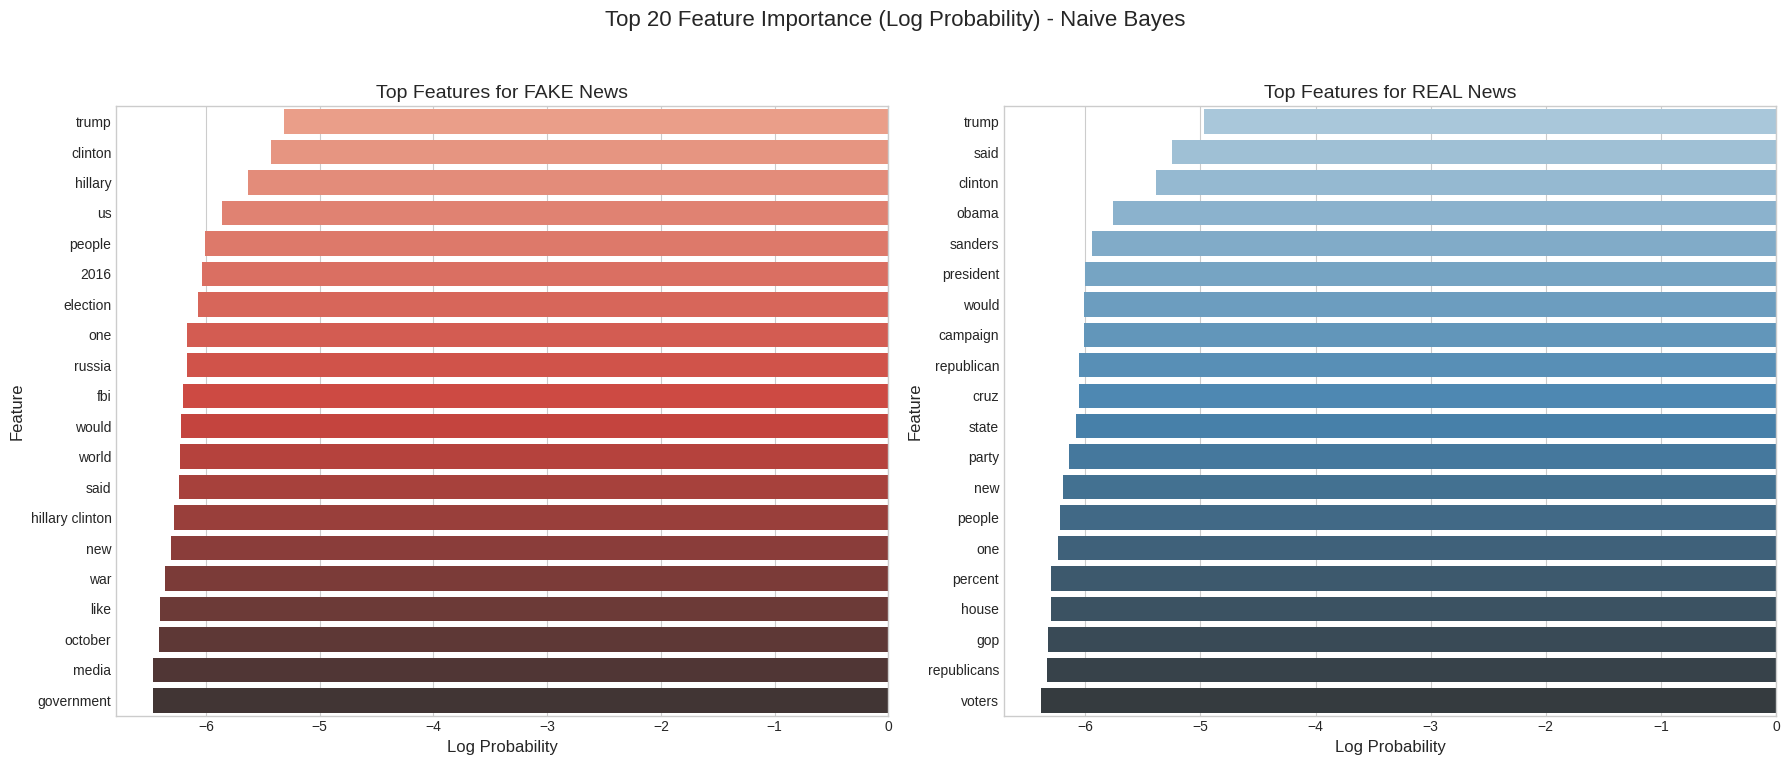

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')

print("\n" + "="*50)
print("VISUALISASI FEATURE IMPORTANCE")
print("="*50)

fake_features_data = []
for i, idx in enumerate(fake_idx):
    fake_features_data.append({'Feature': feature_names[idx], 'Log Probability': log_prob[0][idx]})
df_fake_features = pd.DataFrame(fake_features_data)

real_features_data = []
for i, idx in enumerate(real_idx):
    real_features_data.append({'Feature': feature_names[idx], 'Log Probability': log_prob[1][idx]})
df_real_features = pd.DataFrame(real_features_data)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Top 20 Feature Importance (Log Probability) - Naive Bayes', fontsize=16)

# Bar chart for FAKE news features
sns.barplot(
    x='Log Probability',
    y='Feature',
    data=df_fake_features,
    ax=axes[0],
    palette='Reds_d'
)
axes[0].set_title('Top Features for FAKE News', fontsize=14)
axes[0].set_xlabel('Log Probability', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)

# Bar chart for REAL news features
sns.barplot(
    x='Log Probability',
    y='Feature',
    data=df_real_features,
    ax=axes[1],
    palette='Blues_d'
)
axes[1].set_title('Top Features for REAL News', fontsize=14)
axes[1].set_xlabel('Log Probability', fontsize=12)
axes[1].set_ylabel('Feature', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

frekuensi kemunculan kata pada fake dan real news

In [ ]:
print("="*50)
print("WORD FREQUENCY ANALYSIS")
print("="*50)

fake_texts = df[df['label_encoded'] == 0]['clean_content']
real_texts = df[df['label_encoded'] == 1]['clean_content']

fake_words = " ".join(fake_texts).split()
real_words = " ".join(real_texts).split()

fake_freq = Counter(fake_words)
real_freq = Counter(real_words)


top_n = 20
fake_top20 = fake_freq.most_common(top_n)
real_top20 = real_freq.most_common(top_n)


df_fake_freq = pd.DataFrame(fake_top20, columns=["Word", "Frequency"])
df_real_freq = pd.DataFrame(real_top20, columns=["Word", "Frequency"])

print("\nTop 20 Frequent Words in FAKE News (label=0):")
print(df_fake_freq)

print("\nTop 20 Frequent Words in REAL News (label=1):")
print(df_real_freq)

WORD FREQUENCY ANALYSIS

Top 20 Frequent Words in FAKE News (label=0):
          Word  Frequency
0      Clinton       7081
1        Trump       7080
2       people       5031
3      Hillary       4886
4        would       4852
5          one       4478
6         said       3949
7           US       3137
8         like       3107
9         also       3047
10        2016       2843
11        time       2840
12    election       2679
13  government       2566
14        even       2547
15    American       2535
16       world       2464
17       could       2411
18      Russia       2340
19       Obama       2313

Top 20 Frequent Words in REAL News (label=1):
          Word  Frequency
0         said      17112
1        Trump      16242
2      Clinton      11005
3        would       7752
4        Obama       6231
5       people       5942
6          one       5846
7     campaign       5553
8   Republican       5041
9         also       4911
10       could       4041
11     Sanders       390

visualisasi

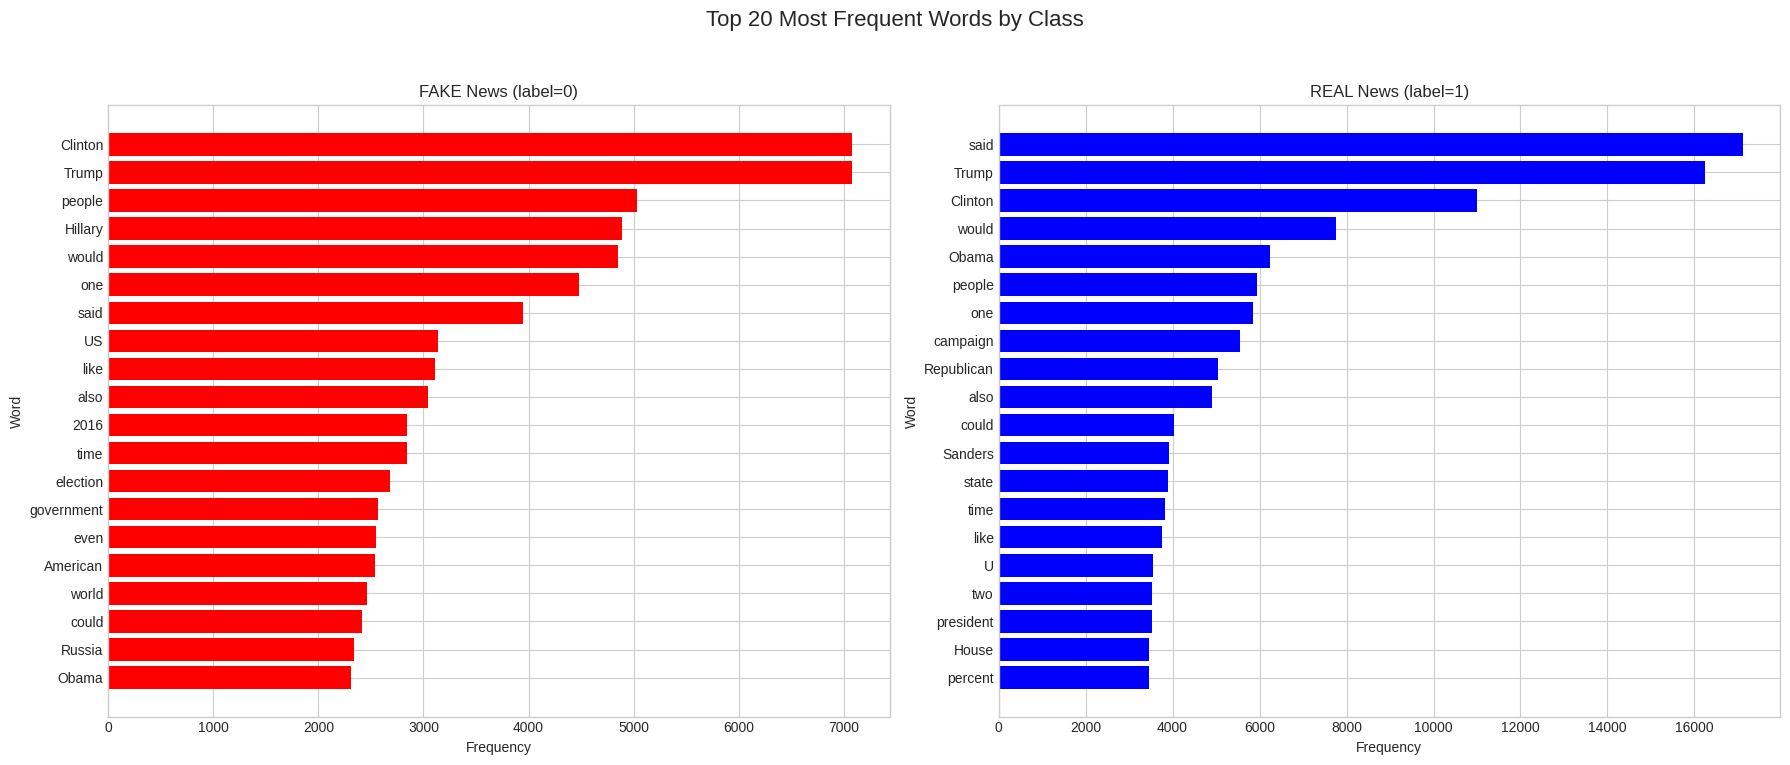

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle("Top 20 Most Frequent Words by Class", fontsize=16)

# FAKE news visualization
axes[0].barh(df_fake_freq["Word"], df_fake_freq["Frequency"], color="red")
axes[0].invert_yaxis()
axes[0].set_title("FAKE News (label=0)")
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Word")

# REAL news visualization
axes[1].barh(df_real_freq["Word"], df_real_freq["Frequency"], color="blue")
axes[1].invert_yaxis()
axes[1].set_title("REAL News (label=1)")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Word")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Cross-Validation

In [ ]:
print("="*50)
print("CROSS-VALIDATION")
print("="*50)

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(nb_model, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print(f"\nCross-validation scores (5-fold): {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

CROSS-VALIDATION

Cross-validation scores (5-fold): [0.88999009 0.90287413 0.87908821 0.88999009 0.87301587]
Mean CV Accuracy: 0.8870 (+/- 0.0206)


Hyperparameter Tuning

In [ ]:
print("="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}

# Grid search
grid_search = GridSearchCV(
    MultinomialNB(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_tfidf, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

best_nb = grid_search.best_estimator_
best_nb.fit(X_train_tfidf, y_train)

y_pred_best = best_nb.predict(X_test_tfidf)
best_accuracy = accuracy_score(y_test, y_pred_best)

print(f"\nBest model test accuracy: {best_accuracy:.4f}")
print(f"Improvement: {(best_accuracy - accuracy):.4f}")

HYPERPARAMETER TUNING
Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'alpha': 0.01, 'fit_prior': True}
Best cross-validation score: 0.8892

Best model test accuracy: 0.8835
Improvement: 0.0024


Error Analysis

In [ ]:
print("="*50)
print("ERROR ANALYSIS")
print("="*50)

results_df = pd.DataFrame({
    'True_Label': y_test.values,
    'Predicted_Label': y_pred,
    'Content': X_test.values
})

results_df['True_Label_Text'] = results_df['True_Label'].map({0: 'FAKE', 1: 'REAL'})
results_df['Predicted_Label_Text'] = results_df['Predicted_Label'].map({0: 'FAKE', 1: 'REAL'})

misclassified = results_df[results_df['True_Label'] != results_df['Predicted_Label']]
print(f"\nNumber of misclassified samples: {len(misclassified)} ({len(misclassified)/len(y_test)*100:.2f}%)")

print("\nExamples of misclassified news:")
for i, (idx, row) in enumerate(misclassified.head(5).iterrows()):
    print(f"\nExample {i+1}:")
    print(f"True Label: {row['True_Label_Text']}")
    print(f"Predicted: {row['Predicted_Label_Text']}")
    content_preview = row['Content'][:200] + "..." if len(row['Content']) > 200 else row['Content']
    print(f"Content Preview: {content_preview}")
    print("-" * 50)

ERROR ANALYSIS

Number of misclassified samples: 150 (11.89%)

Examples of misclassified news:

Example 1:
True Label: REAL
Predicted: FAKE
Content Preview: Cuba possible lung cancer vaccine America test United States Cuba taken major steps end 50 years hostility researchers think Americans could reap unexpected benefit better access Cuban medical innovat...
--------------------------------------------------

Example 2:
True Label: REAL
Predicted: FAKE
Content Preview: Profit sharing supposed silver bullet middle class success happened core commitment American economy give workers fair share productivity profits created seriously question become abundantly clear las...
--------------------------------------------------

Example 3:
True Label: REAL
Predicted: FAKE
Content Preview: Connecticut highest court approves forced chemotherapy teen Connecticut teenager tried reject life saving chemotherapy Hodgkin lymphoma forced undergo treatment anyway state Supreme Court ruled Thursd...
-----

In [ ]:
print("="*50)
print("ERROR ANALYSIS")
print("="*50)

results_df = pd.DataFrame({
    'True_Label': y_test.values,
    'Predicted_Label': y_pred,
    'Content': X_test.values
})

results_df['True_Label_Text'] = results_df['True_Label'].map({0: 'FAKE', 1: 'REAL'})
results_df['Predicted_Label_Text'] = results_df['Predicted_Label'].map({0: 'FAKE', 1: 'REAL'})

misclassified = results_df[results_df['True_Label'] != results_df['Predicted_Label']]
print(f"\nNumber of misclassified samples: {len(misclassified)} ({len(misclassified)/len(y_test)*100:.2f}%)")

print("\nExamples of misclassified news:")
for i, (idx, row) in enumerate(misclassified.head(5).iterrows()):
    print(f"\nExample {i+1}:")
    print(f"True Label: {row['True_Label_Text']}")
    print(f"Predicted: {row['Predicted_Label_Text']}")
    content_preview = row['Content'][:200] + "..." if len(row['Content']) > 200 else row['Content']
    print(f"Content Preview: {content_preview}")
    print("-" * 50)

ERROR ANALYSIS

Number of misclassified samples: 150 (11.89%)

Examples of misclassified news:

Example 1:
True Label: REAL
Predicted: FAKE
Content Preview: Cuba possible lung cancer vaccine America test United States Cuba taken major steps end 50 years hostility researchers think Americans could reap unexpected benefit better access Cuban medical innovat...
--------------------------------------------------

Example 2:
True Label: REAL
Predicted: FAKE
Content Preview: Profit sharing supposed silver bullet middle class success happened core commitment American economy give workers fair share productivity profits created seriously question become abundantly clear las...
--------------------------------------------------

Example 3:
True Label: REAL
Predicted: FAKE
Content Preview: Connecticut highest court approves forced chemotherapy teen Connecticut teenager tried reject life saving chemotherapy Hodgkin lymphoma forced undergo treatment anyway state Supreme Court ruled Thursd...
-----

In [ ]:
print("="*50)
print("MODEL SAVING")
print("="*50)

import joblib
import os

os.makedirs('models', exist_ok=True)

joblib.dump(best_nb, 'models/naive_bayes_model.pkl')
joblib.dump(tfidf_vectorizer, 'models/tfidf_vectorizer.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

print("Model, vectorizer, and label encoder saved successfully!")

MODEL SAVING
Model, vectorizer, and label encoder saved successfully!


In [ ]:
def predict_news(text):
    cleaned_text = clean_text(text)

    text_tfidf = tfidf_vectorizer.transform([cleaned_text])

    prediction = best_nb.predict(text_tfidf)
    probability = best_nb.predict_proba(text_tfidf)

    label = label_encoder.inverse_transform(prediction)[0]

    return {
        'prediction': label,
        'probability_fake': probability[0][0],
        'probability_real': probability[0][1],
        'is_fake': label == 'FAKE'
    }

print("="*50)
print("TEST PREDICTION")
print("="*50)

test_cases = [
    "Breaking news: Scientists discover new treatment for cancer that shows 95% success rate in trials.",
    "Aliens have landed in New York City and are taking over government buildings, says anonymous source.",
    "The president announced new economic policies aimed at reducing inflation and creating jobs."
]

for i, test_text in enumerate(test_cases):
    result = predict_news(test_text)
    print(f"\nTest Case {i+1}:")
    print(f"Text: {test_text[:100]}...")
    print(f"Prediction: {result['prediction']}")
    print(f"Probability (Fake): {result['probability_fake']:.4f}")
    print(f"Probability (Real): {result['probability_real']:.4f}")

TEST PREDICTION

Test Case 1:
Text: Breaking news: Scientists discover new treatment for cancer that shows 95% success rate in trials....
Prediction: FAKE
Probability (Fake): 0.9513
Probability (Real): 0.0487

Test Case 2:
Text: Aliens have landed in New York City and are taking over government buildings, says anonymous source....
Prediction: FAKE
Probability (Fake): 0.8809
Probability (Real): 0.1191

Test Case 3:
Text: The president announced new economic policies aimed at reducing inflation and creating jobs....
Prediction: REAL
Probability (Fake): 0.3666
Probability (Real): 0.6334


In [ ]:
print("="*50)
print("PERFORMANCE SUMMARY")
print("="*50)

# Dataset statistics
print(f"\nDataset Statistics:")
print(f"Total samples: {len(df)}")
print(f"Fake news (label=0): {len(df[df['label_encoded'] == 0])}")
print(f"Real news (label=1): {len(df[df['label_encoded'] == 1])}")

# Model performance summary
print(f"\nModel Performance Summary:")
print(f"Initial Accuracy: {accuracy:.4f}")
print(f"Best Model Accuracy: {best_accuracy:.4f}")
print(f"Precision (Real=1): {precision_score(y_test, y_pred_best, pos_label=1):.4f}")
print(f"Recall (Real=1): {recall_score(y_test, y_pred_best, pos_label=1):.4f}")
print(f"F1-Score (Real=1): {f1_score(y_test, y_pred_best, pos_label=1):.4f}")

print("\n✓ Preprocessing completed successfully")
print("✓ Naive Bayes model trained and optimized")
print("✓ Model evaluation metrics calculated")
print("✓ Model saved for future use")


PERFORMANCE SUMMARY

Dataset Statistics:
Total samples: 6306
Fake news (label=0): 3152
Real news (label=1): 3154

Model Performance Summary:
Initial Accuracy: 0.8811
Best Model Accuracy: 0.8835
Precision (Real=1): 0.9158
Recall (Real=1): 0.8447
F1-Score (Real=1): 0.8788

✓ Preprocessing completed successfully
✓ Naive Bayes model trained and optimized
✓ Model evaluation metrics calculated
✓ Model saved for future use
